## Main analysis for Capstone

Importing all libraries first

In [1]:
# For Google Colab, have to run this every time at startup
!pip install lifelines

     |████████████████████████████████| 419kB 4.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections

import warnings
warnings.filterwarnings("ignore")
import joblib

from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.weightstats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from sklearn.cluster import KMeans, OPTICS

from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.pipeline import Pipeline as imPipeline

import tensorflow as tf

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

from sklearn.mixture import GaussianMixture

First load the source csv file into `pandas`:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_grand = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NSCLC-Radiomics-agg-padded.csv')

Define some boolean variables based on whether the patient has died (`deadstatus.event`==1) and the registered survival time of the patient. For this study, we look at the patients at 1-year, 3-year, and 5-year marks.

In [0]:
dead = df_grand['deadstatus.event'].astype(bool)

mask_1yr = (df_grand['Survival.time'] >= 365)
mask_3yr = (df_grand['Survival.time'] >= 3*365)
mask_5yr = (df_grand['Survival.time'] >= 5*365)

In [0]:
df_tf = df_grand.copy()

Transforming data based on EDA:

In [0]:
# Originally, define a small epsilon such that features can be log-transformed after zero-padding
# All tumours have since been aggregated, so zero-padding is no longer necessary
eps = 0

for i in range(1):
    str_i = str(i)
    
    # Shape
    df_tf.drop(columns=['shape_VoxelVolume_'+str_i, 
                        'shape_Maximum2DDiameterColumn_'+str_i, 
                        'shape_Maximum2DDiameterRow_'+str_i], inplace=True)
    
    df_tf['log_shape_MeshVolume_'+str_i] = np.log( df_tf['shape_MeshVolume_'+str_i] + eps )
    df_tf.drop(columns=['shape_MeshVolume_' + str_i])
    
    # GLDM
    df_tf.drop(columns=['gldm_LargeDependenceEmphasis_'+str_i], 
               inplace = True)
    
    df_tf['log_gldm_GrayLevelVariance_' + str_i] = np.log(df_tf['gldm_GrayLevelVariance_' + str_i] + eps)
    df_tf['log_gldm_DependenceNonUniformity_' + str_i] = np.log(df_tf['gldm_DependenceNonUniformity_' + str_i] + eps)
    df_tf['log_gldm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['gldm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['bc_gldm_LargeDependenceLowGrayLevelEmphasis_' 
          + str_i] = boxcox(df_tf['gldm_LargeDependenceLowGrayLevelEmphasis_' + str_i] + eps)[0]
    df_tf['bc_gldm_SmallDependenceLowGrayLevelEmphasis_' 
          + str_i] = boxcox(df_tf['gldm_SmallDependenceLowGrayLevelEmphasis_' + str_i] + eps)[0]
    df_tf['bc_gldm_LowGrayLevelEmphasis_' + str_i] = boxcox(df_tf['gldm_LowGrayLevelEmphasis_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['gldm_GrayLevelVariance_' + str_i,
                        'gldm_DependenceNonUniformity_' + str_i,
                        'gldm_GrayLevelNonUniformity_' + str_i,
                        'gldm_LargeDependenceLowGrayLevelEmphasis_' + str_i,
                        'gldm_SmallDependenceLowGrayLevelEmphasis_' + str_i,
                        'gldm_LowGrayLevelEmphasis_' + str_i], inplace=True)
    
    # GLCM
    df_tf.drop(columns=['glcm_SumAverage_' + str_i, 
                        'glcm_JointAverage_' + str_i,
                        'glcm_SumEntropy_' + str_i,
                        'glcm_DifferenceEntropy_' + str_i,
                        'glcm_Id_' + str_i,
                        'glcm_Idn_' + str_i,
                        'glcm_ClusterTendency_' + str_i,
                        'glcm_Contrast_' + str_i], inplace=True)
    df_tf['bc_glcm_JointEnergy_' + str_i] = boxcox(df_tf['glcm_JointEnergy_' + str_i] + eps)[0]
    df_tf['log_glcm_DifferenceVariance_' + str_i] = np.log(df_tf['glcm_DifferenceVariance_' + str_i] + eps)
    df_tf['log_glcm_SumSquares_' + str_i] = np.log(df_tf['glcm_SumSquares_' + str_i] + eps)
    df_tf['bc_glcm_ClusterProminence_' + str_i] = boxcox(df_tf['glcm_ClusterProminence_' + str_i] + eps)[0]
    df_tf['bc_glcm_DifferenceAverage_' + str_i] = boxcox(df_tf['glcm_DifferenceAverage_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['glcm_JointEnergy_' + str_i,
                        'glcm_DifferenceVariance_' + str_i,
                        'glcm_SumSquares_' + str_i,
                        'glcm_ClusterProminence_' + str_i,
                        'glcm_DifferenceAverage_' + str_i], inplace=True)
    
    # First order
    df_tf.drop(columns=['firstorder_RobustMeanAbsoluteDeviation_' + str_i, 
                        'firstorder_MeanAbsoluteDeviation_' + str_i,
                        'firstorder_TotalEnergy_' + str_i], inplace=True)
    df_tf['bc_firstorder_InterquartileRange_' + str_i] = boxcox(df_tf['firstorder_InterquartileRange_' + str_i] + eps)[0]
    df_tf['log_firstorder_Energy_' + str_i] = np.log(df_tf['firstorder_Energy_' + str_i] + eps)
    df_tf['log_firstorder_Kurtosis_' + str_i] = np.log(df_tf['firstorder_Kurtosis_' + str_i] + eps)
    df_tf['log_firstorder_RootMeanSquared_' + str_i] = np.log(df_tf['firstorder_RootMeanSquared_' + str_i] + eps)
    
    # GLRLM
    df_tf.drop(columns=['glrlm_ShortRunLowGrayLevelEmphasis_' + str_i,
                        'glrlm_LowGrayLevelRunEmphasis_' + str_i,
                        'glrlm_LongRunEmphasis_' + str_i,
                        'glrlm_RunLengthNonUniformityNormalized_' + str_i,
                        'glrlm_ShortRunEmphasis_' + str_i], inplace=True)
    df_tf['log_glrlm_GrayLevelVariance_' + str_i] = np.log(df_tf['glrlm_GrayLevelVariance_' + str_i] + eps)
    df_tf['log_glrlm_RunVariance_' + str_i] = np.log(df_tf['glrlm_RunVariance_' + str_i] + eps)
    df_tf['log_glrlm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['glrlm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['log_glrlm_RunLengthNonUniformity_' + str_i] = np.log(df_tf['glrlm_RunLengthNonUniformity_' + str_i] + eps)
    df_tf['bc_glrlm_LongRunLowGrayLevelEmphasis_' + str_i] = boxcox(df_tf['glrlm_LongRunLowGrayLevelEmphasis_' 
                                                                          + str_i] + eps)[0]
    
    df_tf.drop(columns=['glrlm_GrayLevelVariance_' + str_i,
                        'glrlm_RunVariance_' + str_i,
                        'glrlm_GrayLevelNonUniformity_' + str_i,
                        'glrlm_RunLengthNonUniformity_' + str_i,
                        'glrlm_LongRunLowGrayLevelEmphasis_' + str_i], inplace = True)
    
    # GLSZM
    df_tf.drop(columns=['glszm_LargeAreaEmphasis_' + str_i,
                        'glszm_LargeAreaHighGrayLevelEmphasis_' + str_i,
                        'glszm_SmallAreaEmphasis_' + str_i,
                        'glszm_SmallAreaHighGrayLevelEmphasis_' + str_i,
                        'glszm_SmallAreaLowGrayLevelEmphasis_' + str_i], inplace=True)
    df_tf['log_glszm_GrayLevelVariance_' + str_i] = boxcox(df_tf['glszm_GrayLevelVariance_' + str_i] + eps)[0]
    df_tf['bc_glszm_ZoneVariance_' + str_i] = boxcox(df_tf['glszm_ZoneVariance_' + str_i] + eps)[0]
    df_tf['log_glszm_GrayLevelNonUniformityNormalized_' + str_i] = np.log(df_tf['glszm_GrayLevelNonUniformityNormalized_' 
                                                                                + str_i] + eps)
    df_tf['log_glszm_SizeZoneNonUniformity_' + str_i] = np.log(df_tf['glszm_SizeZoneNonUniformity_' + str_i] + eps)
    df_tf['log_glszm_GrayLevelNonUniformity_' + str_i] = np.log(df_tf['glszm_GrayLevelNonUniformity_' + str_i] + eps)
    df_tf['log_glszm_ZonePercentage_' + str_i] = np.log(df_tf['glszm_ZonePercentage_' + str_i] + eps)
    df_tf['log_glszm_LargeAreaLowGrayLevelEmphasis_' + str_i] = np.log(df_tf['glszm_LargeAreaLowGrayLevelEmphasis_' 
                                                                             + str_i] + eps)
    df_tf['bc_glszm_LowGrayLevelZoneEmphasis_' + str_i] = boxcox(df_grand['glszm_LowGrayLevelZoneEmphasis_' + str_i] + eps)[0]
    
    df_tf.drop(columns=['glszm_GrayLevelVariance_' + str_i,
                        'glszm_ZoneVariance_' + str_i,
                        'glszm_GrayLevelNonUniformityNormalized_' + str_i,
                        'glszm_SizeZoneNonUniformity_' + str_i,
                        'glszm_GrayLevelNonUniformity_' + str_i,
                        'glszm_ZonePercentage_' + str_i,
                        'glszm_LargeAreaLowGrayLevelEmphasis_' + str_i,
                        'glszm_LowGrayLevelZoneEmphasis_' + str_i], inplace=True)

In [0]:
# Number of features at the end
num_feat = len(df_tf.columns[df_tf.columns.str.contains('_0')])

In [0]:
feat_mask = df_tf.columns.str.contains('_0')

---
### 1-year analysis:

We look at patients satisfying one of the two following criteria:
- The patient has passed away, and his/ her survival time is definite; OR
- The patient has survived past the 1-year mark regardless whether the patient has passed away

In [0]:
X1 = df_tf[mask_1yr | dead][df_tf.columns[feat_mask]]
y1 = (df_tf[mask_1yr | dead]['Survival.time']> 365).astype(int)

In [0]:
X1 = X1.astype(float)

Looking at the total number of patients being studied here:

In [0]:
y1.shape

(418,)

Split the data into training set and test set:

In [0]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=1)

Look at the class imbalance:

In [0]:
y1_train.value_counts()

1    190
0    102
Name: Survival.time, dtype: int64

Hence there are 190 patients in the training set who have survived for more than 1 year, and 102 who have not.

We scale all features in the training set such that all features centred at zero and have variances of 1. The test set is also scaled, BUT with the scaling factors determined from the training set:

In [0]:
my_scaler = StandardScaler()
X1_train = my_scaler.fit_transform(X1_train)
X1_test = my_scaler.transform(X1_test)

Then run through various models:

#### Logistic Regression

In [0]:
my_logit = LogisticRegression()
my_logit.fit(X1_train, y1_train)
my_logit.score(X1_train, y1_train)

0.7705479452054794

The test accuracy for the logistic regression model is:

In [0]:
my_logit.score(X1_test, y1_test)

0.6111111111111112

To further optimize the results, run a grid search:
- Try LASSO (i.e. `penalty='l1'`) and Ridge regression (i.e. `penalty='l2'`)
- Try different normalization strengths (for C, the inverse of the normalization strengths, ranging from $10^{-6}$ to $10^6$)

In [0]:
estimators = [('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'logreg_1yr.pkl')

['logreg_1yr.pkl']

The optimized hyperparameters are:

In [0]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

The score on the training set is:

In [0]:
fittedgrid.score(X1_train, y1_train)

0.7328767123287672

While the score on the test set is:

In [0]:
fittedgrid.score(X1_test, y1_test)

0.626984126984127

Plot some graphs! Define some lists first, then write into a dataframe:

In [0]:
logit_grid_C = fittedgrid.cv_results_['param_model__C'].data

logit_grid_penalty =fittedgrid.cv_results_['param_model__penalty'].data

logit_grid_score = fittedgrid.cv_results_['mean_test_score']

In [0]:
df_logit = pd.DataFrame({'C': logit_grid_C,
                         'penalty': logit_grid_penalty,
                         'score': logit_grid_score})
df_logit.head()

,C,penalty,score
0,1e-06,l1,0.650731
1,1e-06,l2,0.650731
2,1e-05,l1,0.650731
3,1e-05,l2,0.650731
4,0.0001,l1,0.650731


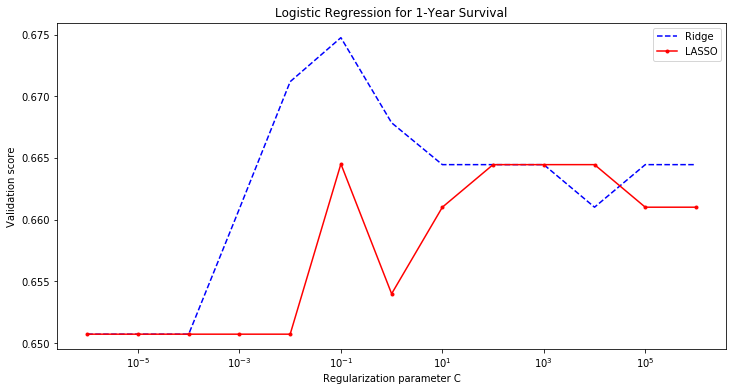

In [0]:
plt.figure(figsize=(12,6))
plt.plot(df_logit[df_logit['penalty']=='l2']['C'], df_logit[df_logit['penalty']=='l2']['score'], 'b--', label='Ridge')
plt.plot(df_logit[df_logit['penalty']=='l1']['C'], df_logit[df_logit['penalty']=='l1']['score'], 'r.-', label='LASSO')
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

Since the accuracy score is so low, and there is a slight imbalance in the classes, let us print out the f1-score and the confusion matrix also for the test set:

In [0]:
y_pred_logit = fittedgrid.predict(X1_test)
print(classification_report(y1_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



Repeat the logistic regression with principal component analysis:

In [0]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [LogisticRegression(solver='saga')], 
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid_pca = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'logreg_pca_1yr.pkl')

['logreg_pca_1yr.pkl']

In [0]:
fittedgrid_pca.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=45,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
fittedgrid_pca.best_params_['pca__n_components']

45

In [0]:
fittedgrid_pca.score(X1_train, y1_train)

0.7328767123287672

In [0]:
fittedgrid_pca.score(X1_test, y1_test)

0.626984126984127

In [0]:
y_pred_logit_pca = fittedgrid_pca.predict(X1_test)
print(classification_report(y1_test, y_pred_logit_pca))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



In [0]:
logit_pca_grid_C = fittedgrid_pca.cv_results_['param_model__C'].data

logit_pca_grid_penalty =fittedgrid_pca.cv_results_['param_model__penalty'].data

logit_pca_grid_score = fittedgrid_pca.cv_results_['mean_test_score']

logit_pca_grid_n_components = fittedgrid_pca.cv_results_['param_pca__n_components'].data

In [0]:
df_logit_pca = pd.DataFrame({'C': logit_pca_grid_C,
                             'penalty': logit_pca_grid_penalty,
                             'n_components': logit_pca_grid_n_components,
                             'score': logit_pca_grid_score})
df_logit_pca.head()

,C,penalty,n_components,score
0,1e-06,l1,5,0.650731
1,1e-06,l1,10,0.650731
2,1e-06,l1,15,0.650731
3,1e-06,l1,20,0.650731
4,1e-06,l1,25,0.650731


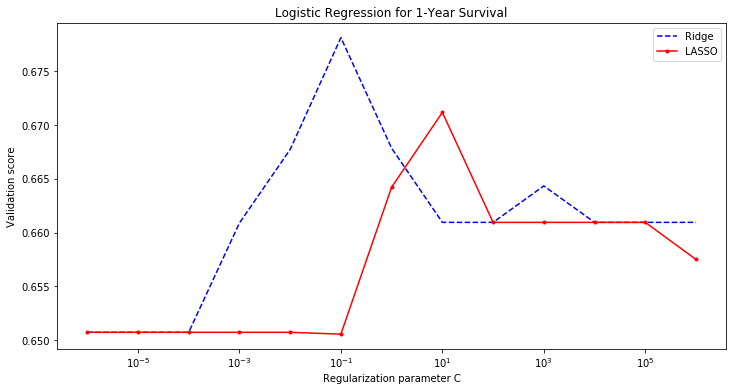

In [0]:
n_PCA = fittedgrid_pca.best_params_['pca__n_components']

plt.figure(figsize=(12,6))
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['n_components']==n_PCA)]['C'], 
         df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['n_components']==n_PCA)]['score'], 'b--', label='Ridge')
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['n_components']==n_PCA)]['C'], 
         df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['n_components']==n_PCA)]['score'], 'r.-', label='LASSO')
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

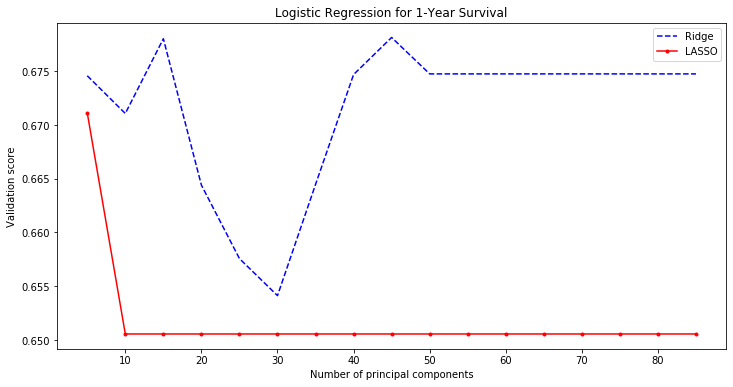

In [0]:
best_C = fittedgrid_pca.best_params_['model__C']

plt.figure(figsize=(12,6))
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['C']==best_C)]['n_components'], 
         df_logit_pca[(df_logit_pca['penalty']=='l2') & 
                      (df_logit_pca['C']==best_C)]['score'], 'b--', label='Ridge')
plt.plot(df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['C']==best_C)]['n_components'], 
         df_logit_pca[(df_logit_pca['penalty']=='l1') & 
                      (df_logit_pca['C']==best_C)]['score'], 'r.-', label='LASSO')
plt.xlabel('Number of principal components')
plt.ylabel('Validation score')
plt.title('Logistic Regression for 1-Year Survival')
plt.legend()
plt.show()

In [0]:
fittedgrid_pca.score(X1_train, y1_train)

0.7328767123287672

In [0]:
fittedgrid_pca.score(X1_test, y1_test)

0.626984126984127

In [0]:
y1_pred_pca = fittedgrid_pca.predict(X1_test)
print(classification_report(y1_test, y1_pred_pca))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34        46
           1       0.66      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.57      0.55      0.54       126
weighted avg       0.60      0.63      0.59       126



#### Decision Tree

In [0]:
estimators = [('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [DecisionTreeClassifier()],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)],
               'pca__n_components': [x for x in range(5,num_feat,5)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'dt_pca_1yr.pkl')

['dt_pca_1yr.pkl']

In [0]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [0]:
fittedgrid.best_score_

0.6573348918760958

In [0]:
fittedgrid.score(X1_train, y1_train)

0.7705479452054794

In [0]:
fittedgrid.score(X1_test, y1_test)

0.6984126984126984

#### Random Forest

In [0]:
my_rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=32)
my_rf.fit(X1_train, y1_train)
my_rf.score(X1_train, y1_train)

0.886986301369863

In [0]:
my_rf.score(X1_test, y1_test)

0.6349206349206349

In [0]:
y_pred_rf = my_rf.predict(X1_test)
print(classification_report(y1_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.28      0.36        46
           1       0.67      0.84      0.74        80

    accuracy                           0.63       126
   macro avg       0.58      0.56      0.55       126
weighted avg       0.61      0.63      0.60       126



In [0]:
estimators = [('pca', PCA()),
              ('model', RandomForestClassifier(n_jobs=-1))]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'model': [RandomForestClassifier(n_jobs=-1)],
               'model__n_estimators': [i for i in range(10,110,10)],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,6)],
               'pca__n_components': [x for x in range(5,num_feat,5)]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'rf_pca_1yr.pkl')

NameError: ignored

In [0]:
fittedgrid.best_score_

In [0]:
fittedgrid.best_estimator_

In [0]:
fittedgrid.score(X1_train, y1_train)

In [0]:
fittedgrid.score(X1_test, y1_test)

#### XGBoost decision tree

In [0]:
estimators = [('pca', PCA()),
              ('model', XGBClassifier(n_jobs=-1))]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [XGBClassifier(n_jobs=-1)], 
               'model__max_depth': [i for i in range(1,11)],
               'model__n_estimators': [i for i in range(10,160,10)]}]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'xgb_pca_1yr.pkl')

['xgb_pca_1yr.pkl']

In [0]:
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=75,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=30, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [0]:
fittedgrid.best_score_

0.6850964348334307

In [0]:
fittedgrid.score(X1_train, y1_train)

0.934931506849315

In [0]:
fittedgrid.score(X1_test, y1_test)

0.626984126984127

In [0]:
xgb_grid_maxdepth = fittedgrid.cv_results_['param_model__max_depth'].data
xgb_grid_n_estimators = fittedgrid.cv_results_['param_model__n_estimators'].data
xgb_grid_n_components = fittedgrid.cv_results_['param_pca__n_components'].data
xgb_grid_score = fittedgrid.cv_results_['mean_test_score']

In [0]:
df_xgb = pd.DataFrame({'max_depth': xgb_grid_maxdepth,
                       'n_estimators': xgb_grid_n_estimators,
                       'n_components': xgb_grid_n_components,
                       'score': xgb_grid_score})

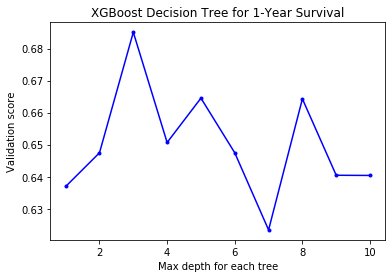

In [0]:
xgb_n_est = fittedgrid.best_params_['model__n_estimators']
xgb_n_comp = fittedgrid.best_params_['pca__n_components']

plt.figure()
plt.plot(df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['n_components']==xgb_n_comp)]['max_depth'], 
         df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['n_components']==xgb_n_comp)]['score'], 'b.-')
plt.xlabel('Max depth for each tree')
plt.ylabel('Validation score')
plt.title('XGBoost Decision Tree for 1-Year Survival')
plt.show()

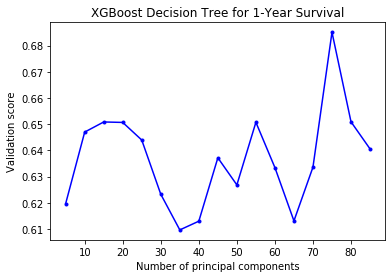

In [0]:
xgb_max_depth = fittedgrid.best_params_['model__max_depth']

plt.figure()
plt.plot(df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['max_depth']==xgb_max_depth)]['n_components'], 
         df_xgb[(df_xgb['n_estimators']==xgb_n_est) &
                (df_xgb['max_depth']==xgb_max_depth)]['score'], 'b.-')
plt.xlabel('Number of principal components')
plt.ylabel('Validation score')
plt.title('XGBoost Decision Tree for 1-Year Survival')
plt.show()

#### Support Vector Machine

In [0]:
estimators = [('pca', PCA()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid = grid.fit(X1_train, y1_train)

joblib.dump(fittedgrid, 'svm_pca_1yr.pkl')

['svm_pca_1yr.pkl']

In [0]:
fittedgrid.best_params_

{'model': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='poly',
     max_iter=999, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'model__C': 10,
 'model__kernel': 'poly',
 'pca': PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False),
 'pca__n_components': 5}

In [0]:
fittedgrid.best_score_

0.6952074810052601

In [0]:
fittedgrid.score(X1_test, y1_test)

0.6507936507936508

#### Quadratic Discriminant Analysis

In [0]:
my_qda = QuadraticDiscriminantAnalysis()
my_qda.fit(X1_train, y1_train)
joblib.dump(my_qda, 'qda_1yr.pkl')

['qda_1yr.pkl']

In [0]:
my_qda.score(X1_train, y1_train)

1.0

In [0]:
my_qda.score(X1_test, y1_test)

0.6666666666666666


#### Neural network

For the neural network model, I will use the TensorFlow library:

In [0]:
input_size = num_feat
output_size = 2

In [0]:
# Make the placeholder variables:
input_X = tf.placeholder(tf.float32, shape=(None, input_size))
input_y = tf.placeholder(tf.float32, shape=(None, output_size))

In [0]:
# Size of the hidden dimension
num_hidden_1 = 400
num_hidden_2 = 400

# Hidden Unit activations 1
W1 = tf.Variable(tf.random_normal([input_size, num_hidden_1]))
b1 = tf.Variable(tf.random_normal([num_hidden_1])) #bias
hidden_output_1 = tf.nn.elu(tf.add(tf.matmul(input_X,W1), b1)) # Relu for hidden layer

# Hidden Unit activations 2
W2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
b2 = tf.Variable(tf.random_normal([num_hidden_2])) #bias
hidden_output_2 = tf.nn.elu(tf.add(tf.matmul(hidden_output_1,W2), b2)) # Relu for hidden layer

# Output Unit activations
W3 = tf.Variable(tf.random_normal([num_hidden_2, output_size]))
b3 = tf.Variable(tf.random_normal([output_size]))
net_output = tf.nn.softmax(tf.add( tf.matmul(hidden_output_2, W3), b3)) # Softmax for output layer

In [0]:
encoder = LabelBinarizer()

one_hot_encoder = encoder.fit(list(y1_train))
y1_np_train = one_hot_encoder.transform(y1_train)
y1_np_test = one_hot_encoder.transform(y1_test)
y1_np_train = np.hstack((y1_np_train, 1 - y1_np_train))
y1_np_test = np.hstack((y1_np_test, 1 - y1_np_test))

In [0]:
y1_np_train.shape

(292, 2)

In [0]:
# Use cross entropy loss (we're doing classification)
# This is where we link our network to the objective function.
loss = tf.losses.softmax_cross_entropy(input_y, net_output)

# Get accuracy measure
# acc will store the accuracy score of the true labels and our net output
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(input_y, 1), predictions=tf.argmax(net_output, 1))

# Use gradient descent with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(0.1)

# Objective is minimize the loss
train = optimizer.minimize(loss)

In [0]:
# Open a TensorFlow session
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

In [0]:
epochs = 20000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess.run(train, feed_dict={input_X: X1_train, input_y: y1_np_train})
    
    if epoch % 1000 == 0 :
        # Get the training loss
        training_loss = sess.run(loss, feed_dict={input_X: X1_train, input_y: y1_np_train})
        
        score = sess.run([acc, acc_op], feed_dict={input_X: X1_train, input_y: y1_np_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')

# run session to calculate the accuracy score on test set
test_acc,_ = sess.run([acc, acc_op], feed_dict={input_X: X1_test, input_y: y1_np_test})
print(test_acc)

Epoch: 0, Loss: 0.717, Accuracy: 0.596
Epoch: 1000, Loss: 0.717, Accuracy: 0.596
Epoch: 2000, Loss: 0.717, Accuracy: 0.596
Epoch: 3000, Loss: 0.717, Accuracy: 0.596
Epoch: 4000, Loss: 0.717, Accuracy: 0.596
Epoch: 5000, Loss: 0.717, Accuracy: 0.596
Epoch: 6000, Loss: 0.717, Accuracy: 0.596
Epoch: 7000, Loss: 0.717, Accuracy: 0.596
Epoch: 8000, Loss: 0.717, Accuracy: 0.596
Epoch: 9000, Loss: 0.717, Accuracy: 0.596
Epoch: 10000, Loss: 0.717, Accuracy: 0.596
Epoch: 11000, Loss: 0.717, Accuracy: 0.596
Epoch: 12000, Loss: 0.717, Accuracy: 0.596
Epoch: 13000, Loss: 0.717, Accuracy: 0.596
Epoch: 14000, Loss: 0.717, Accuracy: 0.596
Epoch: 15000, Loss: 0.717, Accuracy: 0.596
Epoch: 16000, Loss: 0.717, Accuracy: 0.596
Epoch: 17000, Loss: 0.717, Accuracy: 0.596
Epoch: 18000, Loss: 0.717, Accuracy: 0.596
Epoch: 19000, Loss: 0.717, Accuracy: 0.596
0.5958904


---

### 3-year analysis
For the patients surviving for more than 3 years

In [0]:
X3 = df_tf[mask_3yr | dead][df_tf.columns[feat_mask]]
y3 = (df_tf[mask_3yr | dead]['Survival.time'] > 3*365).astype(int)

X3 = X3.astype(float)

In [0]:
y3.shape

(418,)

In [0]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=1)

In [0]:
y3_train.value_counts()

0    203
1     89
Name: Survival.time, dtype: int64

In [0]:
my_scaler3 = StandardScaler()
X3_train = my_scaler3.fit_transform(X3_train)
X3_test = my_scaler3.transform(X3_test)

#### Logistic Regression

In [0]:
my_logit3 = LogisticRegression()
my_logit3.fit(X3_train, y3_train)
my_logit3.score(X3_train, y3_train)

0.7568493150684932

In [0]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'logreg_3yr.pkl')

['logreg_3yr.pkl']

In [0]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-06, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
fittedgrid3.best_score_

0.6952074810052601

In [0]:
my_logit3.score(X3_test, y3_test)

0.7142857142857143

In [0]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

#### Decision Tree

In [0]:
my_dt3 = DecisionTreeClassifier(max_depth=5)
my_dt3.fit(X3_train, y3_train)
my_dt3.score(X3_train, y3_train)

0.839041095890411

In [0]:
my_dt3.score(X3_test, y3_test)

0.6666666666666666

In [0]:
estimators = [('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [DecisionTreeClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'dt_3yr.pkl')

['dt_3yr.pkl']

In [0]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=2,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False)

In [0]:
fittedgrid3.best_score_

0.6988310929281123

In [0]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

#### Random Forest

In [0]:
my_rf3 = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=32)
my_rf3.fit(X3_train, y3_train)
my_rf3.score(X3_train, y3_train)

0.9143835616438356

In [0]:
my_rf3.score(X3_test, y3_test)

0.6904761904761905

In [0]:
y3_pred_rf = my_rf3.predict(X3_test)
print(classification_report(y3_test, y3_pred_rf))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81        85
           1       0.60      0.15      0.24        41

    accuracy                           0.69       126
   macro avg       0.65      0.55      0.52       126
weighted avg       0.67      0.69      0.62       126



In [0]:
estimators = [('pca', PCA()),
              ('model', RandomForestClassifier(n_jobs=-1))]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [RandomForestClassifier(n_jobs=-1)], 
               'model__n_estimators': [i for i in range(10,110,10)],
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'rf_3yr.pkl')

['rf_3yr.pkl']

In [0]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=9, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=7, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=-1,
                                        oob_score=False, random_state=None,
                       

In [0]:
fittedgrid3.best_score_

0.7296317942723552

In [0]:
fittedgrid3.score(X3_test, y3_test)

0.6984126984126984

#### XGBoost decision tree

In [0]:
estimators = [('pca', PCA()),
              ('model', XGBClassifier())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [XGBClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__n_estimators': [i for i in range(10,160,10)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'xgb_3yr.pkl')

['xgb_3yr.pkl']

In [0]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=10,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=1,
                               min_child_weight=1, missing=None,
                               n_estimators=80, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [0]:
fittedgrid3.best_score_

0.7227936879018119

In [0]:
fittedgrid3.score(X3_test, y3_test)

0.6825396825396826

#### Support Vector Machine

In [0]:
estimators = [('pca', PCA()),
              ('model', SVC())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid3 = grid.fit(X3_train, y3_train)

joblib.dump(fittedgrid3, 'svm_3yr.pkl')

['svm_3yr.pkl']

In [0]:
fittedgrid3.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovo', degree=3,
                     gamma='scale', kernel='sigmoid', max_iter=999,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [0]:
fittedgrid3.best_score_

0.7021040327293979

In [0]:
fittedgrid3.score(X3_test, y3_test)

0.6746031746031746

#### Quadratic Discriminant Analysis

In [0]:
my_qda = QuadraticDiscriminantAnalysis()
my_qda.fit(X3_train, y3_train)
joblib.dump(my_qda, 'qda_3yr.pkl')

['qda_3yr.pkl']

In [0]:
my_qda.score(X3_train, y3_train)

1.0

In [0]:
my_qda.score(X3_test, y3_test)

0.6746031746031746

#### Neural network

In [0]:
input_size = num_feat
output_size = 2

In [0]:
# Make the placeholder variables:
input_X = tf.placeholder(tf.float32, shape=(None, input_size))
input_y = tf.placeholder(tf.float32, shape=(None, output_size))

In [0]:
# Size of the hidden dimension
num_hidden_1 = 400
num_hidden_2 = 400

# Hidden Unit activations 1
W1 = tf.Variable(tf.random_normal([input_size, num_hidden_1]))
b1 = tf.Variable(tf.random_normal([num_hidden_1])) #bias
hidden_output_1 = tf.nn.elu(tf.add(tf.matmul(input_X,W1), b1)) # Relu for hidden layer

# Hidden Unit activations 2
W2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
b2 = tf.Variable(tf.random_normal([num_hidden_2])) #bias
hidden_output_2 = tf.nn.elu(tf.add(tf.matmul(hidden_output_1,W2), b2)) # Relu for hidden layer

# Output Unit activations
W3 = tf.Variable(tf.random_normal([num_hidden_2, output_size]))
b3 = tf.Variable(tf.random_normal([output_size]))
net_output = tf.nn.softmax(tf.add( tf.matmul(hidden_output_2, W3), b3)) # Softmax for output layer

In [0]:
encoder = LabelBinarizer()

one_hot_encoder = encoder.fit(list(y3_train))
y3_np_train = one_hot_encoder.transform(y3_train)
y3_np_test = one_hot_encoder.transform(y3_test)
y3_np_train = np.hstack((y3_np_train, 1 - y3_np_train))
y3_np_test = np.hstack((y3_np_test, 1 - y3_np_test))

In [0]:
y3_np_train.shape

(292, 2)

In [0]:
# Use cross entropy loss (we're doing classification)
# This is where we link our network to the objective function.
loss = tf.losses.softmax_cross_entropy(input_y, net_output)

# Get accuracy measure
# acc will store the accuracy score of the true labels and our net output
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(input_y, 1), predictions=tf.argmax(net_output, 1))

# Use gradient descent with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(0.1)

# Objective is minimize the loss
train = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Open a TensorFlow session
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

In [0]:
epochs = 20000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess.run(train, feed_dict={input_X: X3_train, input_y: y3_np_train})
    
    if epoch % 1000 == 0 :
        # Get the training loss
        training_loss = sess.run(loss, feed_dict={input_X: X3_train, input_y: y3_np_train})
        
        score = sess.run([acc, acc_op], feed_dict={input_X: X3_train, input_y: y3_np_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')

# run session to calculate the accuracy score on test set
test_acc,_ = sess.run([acc, acc_op], feed_dict={input_X: X3_test, input_y: y3_np_test})
print(test_acc)

Epoch: 0, Loss: 0.639, Accuracy: 0.675
Epoch: 1000, Loss: 0.639, Accuracy: 0.675
Epoch: 2000, Loss: 0.639, Accuracy: 0.675
Epoch: 3000, Loss: 0.639, Accuracy: 0.675
Epoch: 4000, Loss: 0.639, Accuracy: 0.675
Epoch: 5000, Loss: 0.639, Accuracy: 0.675
Epoch: 6000, Loss: 0.639, Accuracy: 0.675
Epoch: 7000, Loss: 0.639, Accuracy: 0.675
Epoch: 8000, Loss: 0.639, Accuracy: 0.675
Epoch: 9000, Loss: 0.639, Accuracy: 0.675
Epoch: 10000, Loss: 0.639, Accuracy: 0.675
Epoch: 11000, Loss: 0.639, Accuracy: 0.675
Epoch: 12000, Loss: 0.639, Accuracy: 0.675
Epoch: 13000, Loss: 0.639, Accuracy: 0.675
Epoch: 14000, Loss: 0.639, Accuracy: 0.675
Epoch: 15000, Loss: 0.639, Accuracy: 0.675
Epoch: 16000, Loss: 0.639, Accuracy: 0.675
Epoch: 17000, Loss: 0.639, Accuracy: 0.675
Epoch: 18000, Loss: 0.639, Accuracy: 0.675
Epoch: 19000, Loss: 0.639, Accuracy: 0.675
0.6746575


---

### 5-year analysis
For the patients surviving for 5 years:

In [0]:
X5 = df_tf[mask_5yr | dead][df_tf.columns[feat_mask]]
y5 = (df_tf[mask_5yr | dead]['Survival.time'] > 5*365).astype(int)

X5 = X5.astype(float)

In [0]:
y5.shape

(406,)

In [0]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=1)

In [0]:
y5_train.value_counts()

0    233
1     51
Name: Survival.time, dtype: int64

In [0]:
my_scaler5 = StandardScaler()
X5_train = my_scaler5.fit_transform(X5_train)
X5_test = my_scaler5.transform(X5_test)

#### Logistic Regression

In [0]:
my_logit5 = LogisticRegression()
my_logit5.fit(X5_train, y5_train)
my_logit5.score(X5_train, y5_train)

0.852112676056338

In [0]:
my_logit5.score(X5_test, y5_test)

0.7868852459016393

In [0]:
estimators = [('pca', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [{'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'logreg_5yr.pkl')

['logreg_5yr.pkl']

In [0]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-06, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
fittedgrid5.best_score_

0.8204260651629072

In [0]:
fittedgrid5.score(X5_test, y5_test)

0.819672131147541

High accuracy score due to imbalanced dataset. Try oversampling the data using different schemes.

In [0]:
estimators = [('oversample', SMOTE()),
              ('pca', PCA()),
              ('model', LogisticRegression())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SMOTE(), ADASYN(), SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [LogisticRegression(solver='saga')], 
               'model__C': [10**i for i in range(-6,7)],
               'model__penalty': ['l1', 'l2']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'logreg_svmsmote_5yr.pkl')

['logreg_svmsmote_5yr.pkl']

In [0]:
fittedgrid5.best_score_

0.8204260651629072

In [0]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 LogisticRegression(C=1e-06, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
fittedgrid5.score(X5_test, y5_test)

0.819672131147541

In [0]:
y5_pred = fittedgrid5.predict(X5_test)
print(classification_report(y5_test, y5_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       0.00      0.00      0.00        22

    accuracy                           0.82       122
   macro avg       0.41      0.50      0.45       122
weighted avg       0.67      0.82      0.74       122



In [0]:
print('Kappa score: %.5f' % cohen_kappa_score(y5_test, y5_pred))

Kappa score: 0.00000


I will use SVMSMOTE from this point on for the other models in my 5-year survival analysis.

#### Decision Tree

In [0]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [DecisionTreeClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'dt_svmsmote_5yr.pkl')

['dt_svmsmote_5yr.pkl']

In [0]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=65,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=9, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
           

In [0]:
fittedgrid5.best_score_

0.7748120300751881

In [0]:
fittedgrid5.score(X5_train, y5_train)

0.8697183098591549

In [0]:
fittedgrid5.score(X5_test, y5_test)

0.7131147540983607

#### Random Forest

In [0]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', RandomForestClassifier())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [RandomForestClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'rf_svmsmote_5yr.pkl')

In [0]:
fittedgrid5.best_estimator_

In [0]:
fittedgrid5.best_score_

In [0]:
fittedgrid5.score(X5_train, y5_train)

In [0]:
fittedgrid5.score(X5_test, y5_test)

#### XGBoost decision tree

In [0]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', XGBClassifier())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [XGBClassifier()], 
               'model__max_depth': [i for i in range(1,11)],
               'model__min_samples_leaf': [i for i in range(1,11)]}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'xgb_svmsmote_5yr.pkl')

In [0]:
fittedgrid5.best_estimator_

In [0]:
fittedgrid5.best_score_

In [0]:
fittedgrid5.score(X5_train, y5_train)

In [0]:
fittedgrid5.score(X5_test, y5_test)

#### Support Vector Machine

In [0]:
estimators = [('oversample', SVMSMOTE()),
              ('pca', PCA()),
              ('model', SVC())]

pipe = imPipeline(estimators)

param_grid = [{'oversample': [SVMSMOTE()],
               'pca': [PCA()],
               'pca__n_components': [x for x in range(5,num_feat,5)],
               'model': [SVC(decision_function_shape='ovo', max_iter=999)], 
               'model__C': [10**i for i in range(-6,7)],
               'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]

grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
fittedgrid5 = grid.fit(X5_train, y5_train)

joblib.dump(fittedgrid5, 'svm_svmsmote_5yr.pkl')

['svm_svmsmote_5yr.pkl']

In [0]:
fittedgrid5.best_estimator_

Pipeline(memory=None,
         steps=[('oversample',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy='auto',
                          svm_estimator=None)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=65,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovo', degree=3,
                     gamma='scale', kernel='rbf', max_iter=999,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [0]:
fittedgrid5.best_score_

0.7993734335839597

In [0]:
fittedgrid5.score(X5_train, y5_train)

0.8802816901408451

In [0]:
fittedgrid5.score(X5_test, y5_test)

0.7868852459016393

#### Quadratic Discriminant Analysis

In [0]:
my_qda = QuadraticDiscriminantAnalysis()
my_qda.fit(X5_train, y5_train)
joblib.dump(my_qda, 'qda_5yr.pkl')

['qda_5yr.pkl']

In [0]:
my_qda.score(X5_train, y5_train)

0.8450704225352113

In [0]:
my_qda.score(X5_test, y5_test)

0.819672131147541

In [0]:
print(classification_report(y5_test, my_qda.predict(X5_test)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       0.00      0.00      0.00        22

    accuracy                           0.82       122
   macro avg       0.41      0.50      0.45       122
weighted avg       0.67      0.82      0.74       122



Try SMOTE-ing it:

In [0]:
sm = SVMSMOTE(random_state=314)
X5_train_res, y5_train_res = sm.fit_resample(X5_train, y5_train)

In [0]:
my_qda.fit(X5_train_res, y5_train_res)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [0]:
print(classification_report(y5_test, my_qda.predict(X5_test)))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       100
           1       0.00      0.00      0.00        22

    accuracy                           0.82       122
   macro avg       0.41      0.50      0.45       122
weighted avg       0.67      0.82      0.74       122



No improvement on test data

#### Neural network

In [0]:
input_size = num_feat
output_size = 2

In [0]:
# Make the placeholder variables:
input_X = tf.placeholder(tf.float32, shape=(None, input_size))
input_y = tf.placeholder(tf.float32, shape=(None, output_size))

In [0]:
# Size of the hidden dimension
num_hidden_1 = 400
num_hidden_2 = 400

# Hidden Unit activations 1
W1 = tf.Variable(tf.random_normal([input_size, num_hidden_1]))
b1 = tf.Variable(tf.random_normal([num_hidden_1])) #bias
hidden_output_1 = tf.nn.elu(tf.add(tf.matmul(input_X,W1), b1)) # Relu for hidden layer

# Hidden Unit activations 2
W2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2]))
b2 = tf.Variable(tf.random_normal([num_hidden_2])) #bias
hidden_output_2 = tf.nn.elu(tf.add(tf.matmul(hidden_output_1,W2), b2)) # Relu for hidden layer

# Output Unit activations
W3 = tf.Variable(tf.random_normal([num_hidden_2, output_size]))
b3 = tf.Variable(tf.random_normal([output_size]))
net_output = tf.nn.softmax(tf.add( tf.matmul(hidden_output_2, W3), b3)) # Softmax for output layer

In [0]:
encoder = LabelBinarizer()

one_hot_encoder = encoder.fit(list(y5_train))
y5_np_train = one_hot_encoder.transform(y5_train)
y5_np_test = one_hot_encoder.transform(y5_test)
y5_np_train = np.hstack((y5_np_train, 1 - y5_np_train))
y5_np_test = np.hstack((y5_np_test, 1 - y5_np_test))

In [0]:
y5_np_train.shape

(284, 2)

In [0]:
# Use cross entropy loss (we're doing classification)
# This is where we link our network to the objective function.
loss = tf.losses.softmax_cross_entropy(input_y, net_output)

# Get accuracy measure
# acc will store the accuracy score of the true labels and our net output
acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(input_y, 1), predictions=tf.argmax(net_output, 1))

# Use gradient descent with a learning rate of 0.1
optimizer = tf.train.GradientDescentOptimizer(0.1)

# Objective is minimize the loss
train = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Open a TensorFlow session
sess = tf.Session()
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)

In [0]:
epochs = 20000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess.run(train, feed_dict={input_X: X5_train, input_y: y5_np_train})
    
    if epoch % 1000 == 0 :
        # Get the training loss
        training_loss = sess.run(loss, feed_dict={input_X: X5_train, input_y: y5_np_train})
        
        score = sess.run([acc, acc_op], feed_dict={input_X: X5_train, input_y: y5_np_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')

# run session to calculate the accuracy score on test set
test_acc,_ = sess.run([acc, acc_op], feed_dict={input_X: X5_test, input_y: y5_np_test})
print(test_acc)

Epoch: 0, Loss: 0.683, Accuracy: 0.630
Epoch: 1000, Loss: 0.683, Accuracy: 0.630
Epoch: 2000, Loss: 0.683, Accuracy: 0.630
Epoch: 3000, Loss: 0.683, Accuracy: 0.630
Epoch: 4000, Loss: 0.683, Accuracy: 0.630
Epoch: 5000, Loss: 0.683, Accuracy: 0.630
Epoch: 6000, Loss: 0.683, Accuracy: 0.630
Epoch: 7000, Loss: 0.683, Accuracy: 0.630
Epoch: 8000, Loss: 0.683, Accuracy: 0.630
Epoch: 9000, Loss: 0.683, Accuracy: 0.630
Epoch: 10000, Loss: 0.683, Accuracy: 0.630
Epoch: 11000, Loss: 0.683, Accuracy: 0.630
Epoch: 12000, Loss: 0.683, Accuracy: 0.630
Epoch: 13000, Loss: 0.683, Accuracy: 0.630
Epoch: 14000, Loss: 0.683, Accuracy: 0.630
Epoch: 15000, Loss: 0.683, Accuracy: 0.630
Epoch: 16000, Loss: 0.683, Accuracy: 0.630
Epoch: 17000, Loss: 0.683, Accuracy: 0.630
Epoch: 18000, Loss: 0.683, Accuracy: 0.630
Epoch: 19000, Loss: 0.683, Accuracy: 0.630
0.6302817


### Clustering: K-means and OPTICS

In [0]:
X = df_tf[df_tf.columns[feat_mask]]
y = df_tf[['deadstatus.event', 'Survival.time']]

# Train-test split
# Perform K-means cluster on the train set, use clusters for model prediction on median survival time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

my_scaler_cl = StandardScaler()
X_tr_scaled = my_scaler_cl.fit_transform(X_train)
X_tst_scaled = my_scaler_cl.transform(X_test)

#### K-means

##### Optimizing number of clusters

Plot the inertias corresponding to a range of numbers of clusters and determine the "elbow":

In [0]:
nsclc_inertias = []

for i in range(2,8):
  my_kmeans = KMeans(n_clusters=i)
  my_kmeans.fit(X_tr_scaled)

  nsclc_inertias.append(my_kmeans.inertia_)

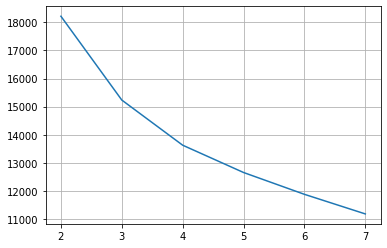

In [12]:
plt.figure()
plt.plot(np.arange(2,8), nsclc_inertias)
plt.grid()
plt.show()

The elbow point seems to be around n=4. Explore the clusters:

In [13]:
n_cl_optimize = 4
my_kmeans = KMeans(n_clusters=n_cl_optimize, random_state=42)
my_kmeans.fit(X_tr_scaled)

collections.Counter(my_kmeans.labels_)

Counter({0: 78, 1: 106, 2: 73, 3: 37})

The number of points in each cluster seems reasonable. Proceed with the analysis:

In [0]:
joblib.dump(my_kmeans, 'kmeans_4_test.pkl')

X_long = X_train.copy()
X_long['Cluster'] = my_kmeans.predict(X_tr_scaled)

#X_long['age'] = df_tf['age']
#X_long['Clinical.T.Stage'] = df_tf['clinical.T.Stage']
#X_long['Clinical.N.Stage'] = df_tf['Clinical.N.Stage']
#X_long['Clinical.M.Stage'] = df_tf['Clinical.M.Stage']
#X_long['Histology'] = df_tf['Histology']
X_long['Survival.time'] = y_train['Survival.time']
X_long['Deadstatus.event'] = y_train['deadstatus.event']

Make some Kaplan-Meier plots

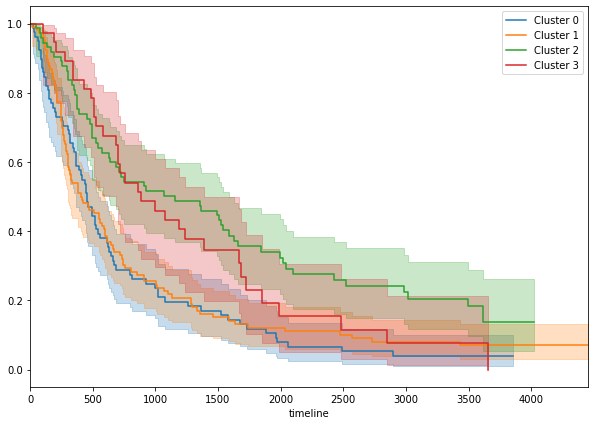

In [15]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,7))

for i in range(n_cl_optimize):
  kmf.fit(X_long[X_long['Cluster']==i]['Survival.time'], 
          X_long[X_long['Cluster']==i]['Deadstatus.event'], 
          label='Cluster '+str(i))

  if (i==0):
    ax1 = kmf.plot()
  else:
    kmf.plot(ax=ax1)

Cluster 1 and Cluster 0 seem to have survival curves very close to each other throughout the timeline. I will re-cluster the data into 3:

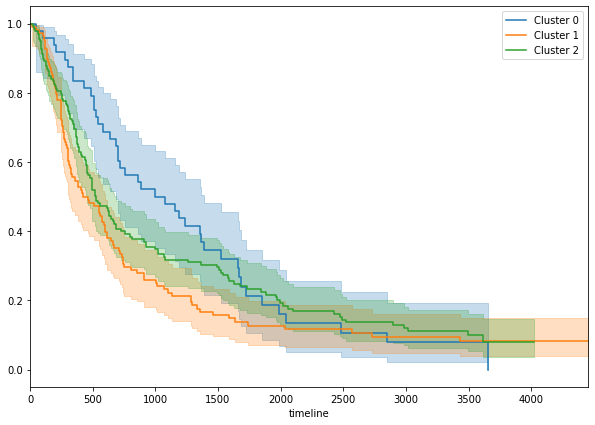

In [37]:
n_cl_optimize = 3
my_kmeans = KMeans(n_clusters=n_cl_optimize, random_state=42)
my_kmeans.fit(X_tr_scaled)

collections.Counter(my_kmeans.labels_)

joblib.dump(my_kmeans, 'kmeans_3.pkl')

X_long = X_train.copy()
X_long['Cluster'] = my_kmeans.predict(X_tr_scaled)

X_long['Survival.time'] = y_train['Survival.time']
X_long['Deadstatus.event'] = y_train['deadstatus.event']

plt.figure(figsize=(10,7))

median_list = []
ci_list = []

for i in range(n_cl_optimize):
  kmf.fit(X_long[X_long['Cluster']==i]['Survival.time'], 
          X_long[X_long['Cluster']==i]['Deadstatus.event'], 
          label='Cluster '+str(i))

  if (i==0):
    ax1 = kmf.plot()
  else:
    kmf.plot(ax=ax1)

  median_list.append(kmf.median_survival_time_)
  ci_list.append(median_survival_times(kmf.confidence_interval_))

Clusters 0 and 1 seem to have some separation in their KM curves. We will explore the distributions according to all three clusters.

##### Statistical significance of differences in survival at different points on timeline

In [17]:
T1 = X_long[X_long['Cluster']==0]['Survival.time']
T2 = X_long[X_long['Cluster']==1]['Survival.time']

E1 = X_long[X_long['Cluster']==0]['Deadstatus.event']
E2 = X_long[X_long['Cluster']==1]['Deadstatus.event']

results_1yr = survival_difference_at_fixed_point_in_time_test(365, T1, T2, event_observed_A=E1, event_observed_B=E2)
results_1yr.print_summary()

So there is a statistically significant difference in the survival rates between two clusters at 1 year.

In [18]:
results_3yr = survival_difference_at_fixed_point_in_time_test(3*365, T1, T2, event_observed_A=E1, event_observed_B=E2)
results_3yr.print_summary()

A statistically significant difference persists in the survival rates between the same two clusters at 3 years.

In [19]:
results_5yr = survival_difference_at_fixed_point_in_time_test(5*365, T1, T2, event_observed_A=E1, event_observed_B=E2)
results_5yr.print_summary()

No statistically significant difference in the survival rates between the same two clusters at the 5-year mark.

##### Characteristics of the different clusters

What are the characteristics between the two clusters?

In [0]:
data_1 = X_tr_scaled[X_long['Cluster']==0]
data_2 = X_tr_scaled[X_long['Cluster']==1]

ttest_results = ttest_ind(data_1, data_2, usevar='unequal')

In [21]:
joblib.dump(ttest_results, 'kmeans_diff.pkl')

['kmeans_diff.pkl']

Storing the cluster data separately:

In [0]:
df_data_1 = pd.DataFrame(data_1, columns=X.columns)
df_data_2 = pd.DataFrame(data_2, columns=X.columns)

In [23]:
joblib.dump(df_data_1, 'df_cl1.pkl')
joblib.dump(df_data_2, 'df_cl2.pkl')

['df_cl2.pkl']

Storing the p-values in a dataframe with indices indicating the variables tested:

In [22]:
df_pval = pd.DataFrame(ttest_results[1], index=X.columns)
df_pval

,0
shape_Maximum3DDiameter_0,2.153122e-23
shape_MeshVolume_0,5.469580e-21
shape_MajorAxisLength_0,2.806385e-10
shape_Sphericity_0,2.740442e-11
shape_LeastAxisLength_0,6.837539e-40
...,...
log_glszm_SizeZoneNonUniformity_0,1.280538e-14
log_glszm_GrayLevelNonUniformity_0,1.289177e-27
log_glszm_ZonePercentage_0,5.169343e-59
log_glszm_LargeAreaLowGrayLevelEmphasis_0,4.611523e-47


In [25]:
joblib.dump(df_pval, 'pvalues_variables.pkl')

['pvalues_variables.pkl']

Apply Holm-Bonferroni Correction to the thresholds:

In [0]:
# No adding 1 in the denominator because of zero-indexing
df_pval['alpha'] = 0.05/(df_pval.shape[0] - np.array(ttest_results[1].argsort()))

In [0]:
df_pval.columns = ['p values', 'alpha']

Compare the p-values with the respective thresholds:

In [0]:
df_pval_sig = df_pval[df_pval['p values'] < df_pval['alpha']]

All features that have statistically significant differences:

In [26]:
df_pval_sig.index

Index(['shape_Maximum3DDiameter_0', 'shape_MeshVolume_0',
       'shape_MajorAxisLength_0', 'shape_Sphericity_0',
       'shape_LeastAxisLength_0', 'shape_SurfaceVolumeRatio_0',
       'shape_Maximum2DDiameterSlice_0', 'shape_SurfaceArea_0',
       'shape_MinorAxisLength_0', 'gldm_HighGrayLevelEmphasis_0',
       'gldm_DependenceEntropy_0', 'gldm_SmallDependenceEmphasis_0',
       'gldm_SmallDependenceHighGrayLevelEmphasis_0',
       'gldm_DependenceNonUniformityNormalized_0', 'gldm_DependenceVariance_0',
       'gldm_LargeDependenceHighGrayLevelEmphasis_0', 'glcm_JointEntropy_0',
       'glcm_ClusterShade_0', 'glcm_MaximumProbability_0', 'glcm_Idmn_0',
       'glcm_InverseVariance_0', 'glcm_Idm_0', 'glcm_Autocorrelation_0',
       'glcm_Imc2_0', 'glcm_Imc1_0', 'firstorder_InterquartileRange_0',
       'firstorder_Skewness_0', 'firstorder_Uniformity_0',
       'firstorder_Median_0', 'firstorder_Maximum_0',
       'firstorder_RootMeanSquared_0', 'firstorder_Entropy_0',
       'firstorde

Maybe just focus on the top 5:

In [27]:
p_ranks = ttest_results[1].argsort()
X.columns[p_ranks[0:5]]

Index(['glrlm_GrayLevelNonUniformityNormalized_0',
       'bc_firstorder_InterquartileRange_0', 'log_glszm_ZonePercentage_0',
       'log_firstorder_Kurtosis_0', 'bc_glszm_ZoneVariance_0'],
      dtype='object')

I will plot the histograms for the five features above. Cluster 0 has the highest 1-year survival, and will be denoted as "Higher survival". Similarly for the other clusters.

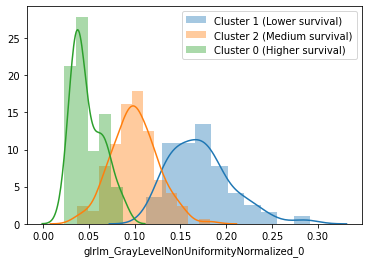

In [32]:
sns.distplot(X_long[X_long['Cluster']==1]['glrlm_GrayLevelNonUniformityNormalized_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['glrlm_GrayLevelNonUniformityNormalized_0'], label='Cluster 2 (Medium survival)')
sns.distplot(X_long[X_long['Cluster']==0]['glrlm_GrayLevelNonUniformityNormalized_0'], label='Cluster 0 (Higher survival)')
plt.legend()
plt.show()

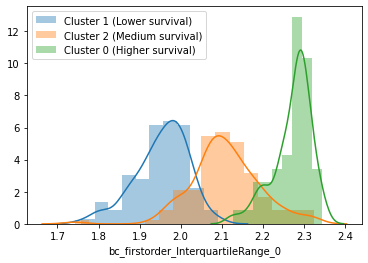

In [31]:
sns.distplot(X_long[X_long['Cluster']==1]['bc_firstorder_InterquartileRange_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['bc_firstorder_InterquartileRange_0'], label='Cluster 2 (Medium survival)')
sns.distplot(X_long[X_long['Cluster']==0]['bc_firstorder_InterquartileRange_0'], label='Cluster 0 (Higher survival)')
plt.legend()
plt.show()

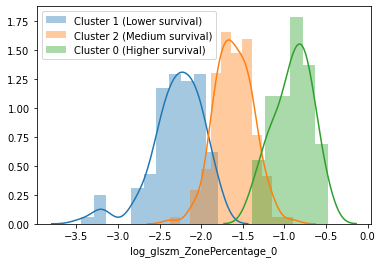

In [35]:
sns.distplot(X_long[X_long['Cluster']==1]['log_glszm_ZonePercentage_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['log_glszm_ZonePercentage_0'], label='Cluster 2 (Medium survival)')
sns.distplot(X_long[X_long['Cluster']==0]['log_glszm_ZonePercentage_0'], label='Cluster 0 (Higher survival)')
plt.legend()
plt.show()

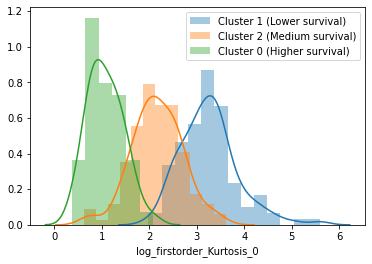

In [34]:
sns.distplot(X_long[X_long['Cluster']==1]['log_firstorder_Kurtosis_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['log_firstorder_Kurtosis_0'], label='Cluster 2 (Medium survival)')
sns.distplot(X_long[X_long['Cluster']==0]['log_firstorder_Kurtosis_0'], label='Cluster 0 (Higher survival)')
plt.legend()
plt.show()

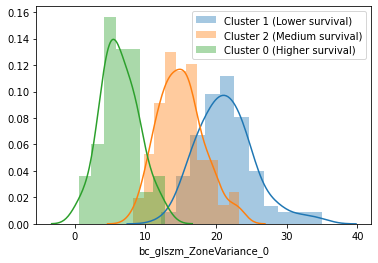

In [33]:
sns.distplot(X_long[X_long['Cluster']==1]['bc_glszm_ZoneVariance_0'], label='Cluster 1 (Lower survival)')
sns.distplot(X_long[X_long['Cluster']==2]['bc_glszm_ZoneVariance_0'], label='Cluster 2 (Medium survival)')
sns.distplot(X_long[X_long['Cluster']==0]['bc_glszm_ZoneVariance_0'], label='Cluster 0 (Higher survival)')
plt.legend()
plt.show()

##### Median survival times for each cluster

In [41]:
for index, param in enumerate(median_list):
  print(f'Median survival time for Cluster {index}: {param}')
  print(f'Confidence interval on median survival for Cluster {index}: \n{ci_list[index]}\n')

Median survival time for Cluster 0: 1000.0
Confidence interval on median survival for Cluster 0: 
     Cluster 0_lower_0.95  Cluster 0_upper_0.95
0.5                 687.0                1391.0

Median survival time for Cluster 1: 423.0
Confidence interval on median survival for Cluster 1: 
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                 311.0                 597.0

Median survival time for Cluster 2: 524.0
Confidence interval on median survival for Cluster 2: 
     Cluster 2_lower_0.95  Cluster 2_upper_0.95
0.5                 456.0                 685.0



#### OPTICS

In [0]:
my_optics = OPTICS(min_samples=10, n_jobs=-1)
my_optics.fit(X_scaled)
joblib.dump(my_optics, 'optics.pkl')

['optics.pkl']

In [0]:
X_long['OPTICS'] = my_optics.labels_

In [0]:
X_long['OPTICS'].value_counts()

-1    408
 0     12
Name: OPTICS, dtype: int64

OPTICS does not work as well

---
## Superceded codes

Try to obtain the median survival time for each cluster:

In [0]:
X_long_wocl = X_long.drop(columns='Cluster')

cph = CoxPHFitter()
cph.fit(X_long, duration_col='Survival.time', event_col='Deadstatus.event')

cph.print_summary()

ConvergenceError: ignored

Two of the clusters seem to differ in the survival rate at the 1-year mark. We can dig a bit deeper here.

How many points for each cluster?

In [0]:
X_long['Cluster'].value_counts()

0    193
2    153
1     74
Name: Cluster, dtype: int64